### **Import Libraries**

In [37]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, roc_auc_score, classification_report, RocCurveDisplay, ConfusionMatrixDisplay
import xgboost as xgb
from matplotlib.colors import LinearSegmentedColormap

# Setting visualization inline
%matplotlib inline

### **Read Dataset**

In [4]:
# Load training and testing datasets
train_df = pd.read_csv("Dataset/Training.csv")
test_df = pd.read_csv("Dataset/Testing.csv")


# Combine both datasets into one dataframe
df = pd.concat([train_df, test_df], ignore_index=True)

# Reset index to ensure it's ordered correctly
df.reset_index(drop=True, inplace=True)

In [6]:
df.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


### **Dataset Overview**

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2768 entries, 0 to 2767
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               2768 non-null   int64  
 1   Glucose                   2768 non-null   int64  
 2   BloodPressure             2768 non-null   int64  
 3   SkinThickness             2768 non-null   int64  
 4   Insulin                   2768 non-null   int64  
 5   BMI                       2768 non-null   float64
 6   DiabetesPedigreeFunction  2768 non-null   float64
 7   Age                       2768 non-null   int64  
 8   Outcome                   2768 non-null   int64  
dtypes: float64(2), int64(7)
memory usage: 194.8 KB


#### Summary Statistics

In [8]:
df.describe().T


,count,mean,std,min,25%,50%,75%,max
Pregnancies,2768.0,3.822616,3.305432,0.000,1.000,3.00,6.00000,17.00
Glucose,2768.0,121.421965,31.721258,0.000,100.000,117.00,142.00000,199.00
BloodPressure,2768.0,68.980491,19.133100,0.000,64.000,71.00,80.00000,122.00
SkinThickness,2768.0,20.549494,15.779713,0.000,0.000,23.00,33.00000,99.00
Insulin,2768.0,79.853324,115.655771,0.000,0.000,36.00,129.00000,846.00
BMI,2768.0,31.976590,7.760540,0.000,27.175,32.10,36.50000,67.10
DiabetesPedigreeFunction,2768.0,0.486277,0.357403,0.078,0.248,0.38,0.64525,2.42
Age,2768.0,32.923049,11.362964,21.000,24.000,29.00,40.00000,81.00
Outcome,2768.0,0.380419,0.485578,0.000,0.000,0.00,1.00000,1.00


### **EDA**

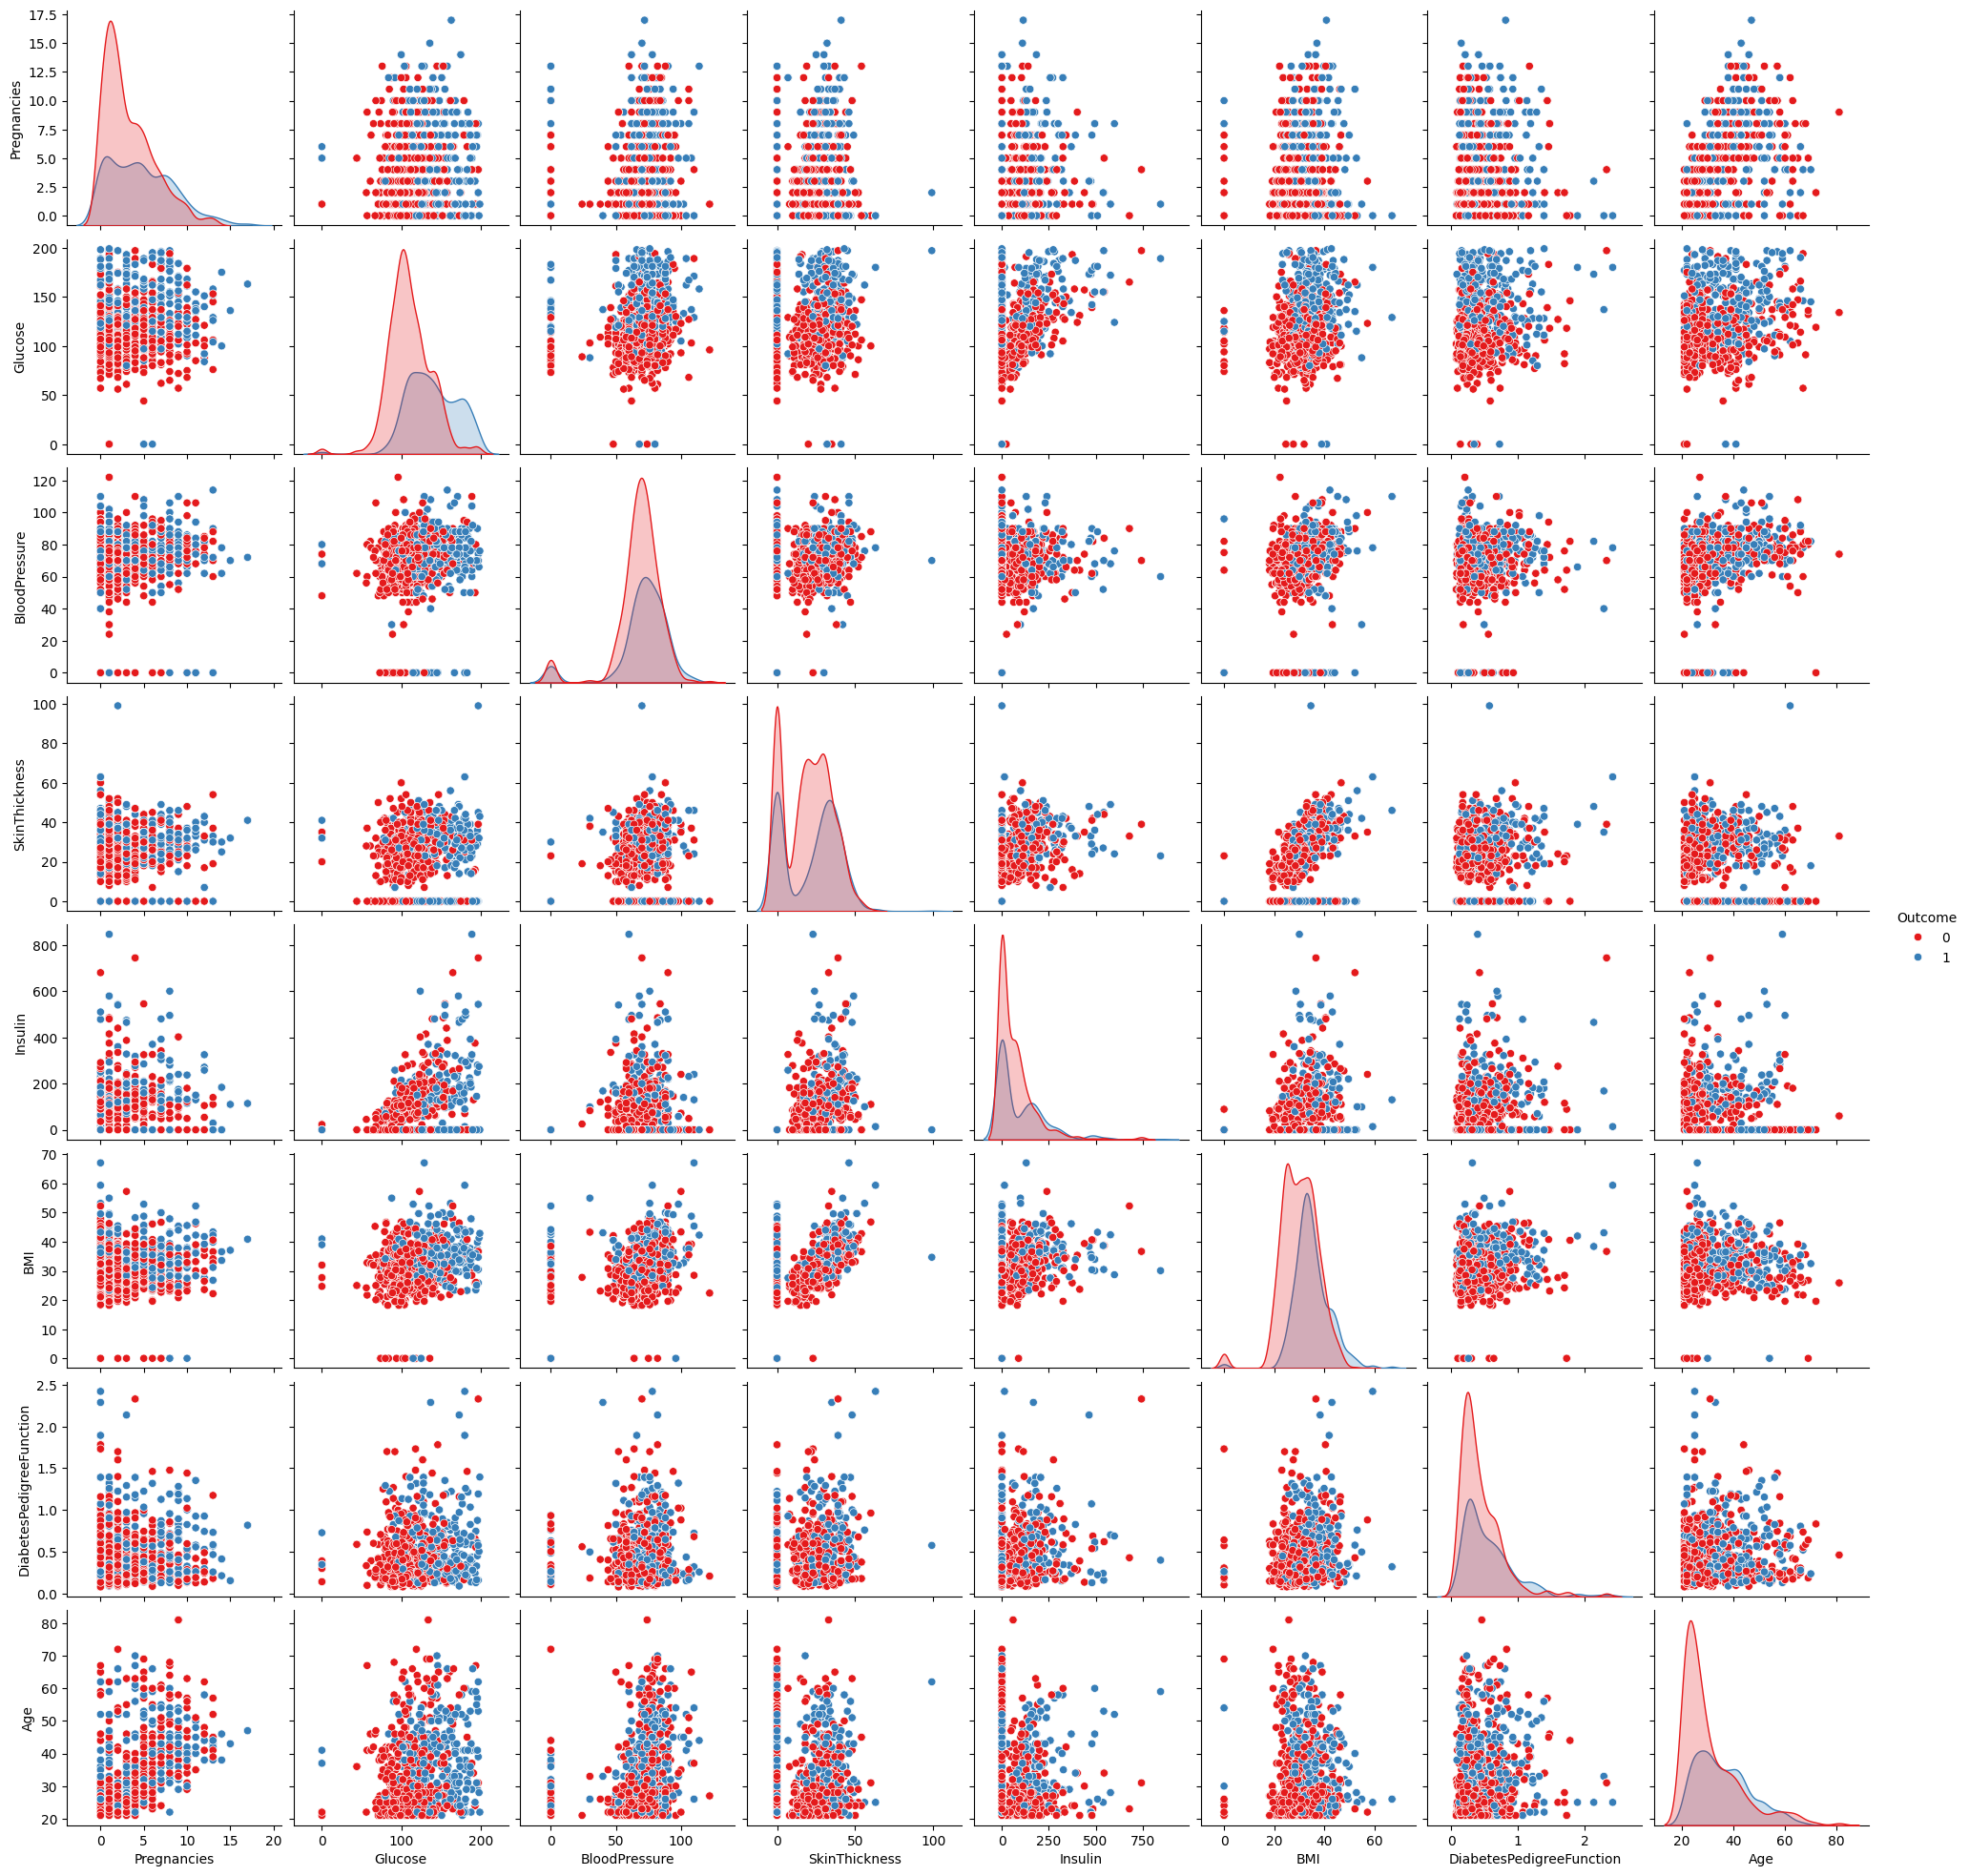

In [9]:
sns.pairplot(df, hue='Outcome',palette ='Set1')


#### Unvariate Analysis

In [10]:
numerical_columns = df.drop(columns=['Outcome']).columns
df_numerical = df[numerical_columns]

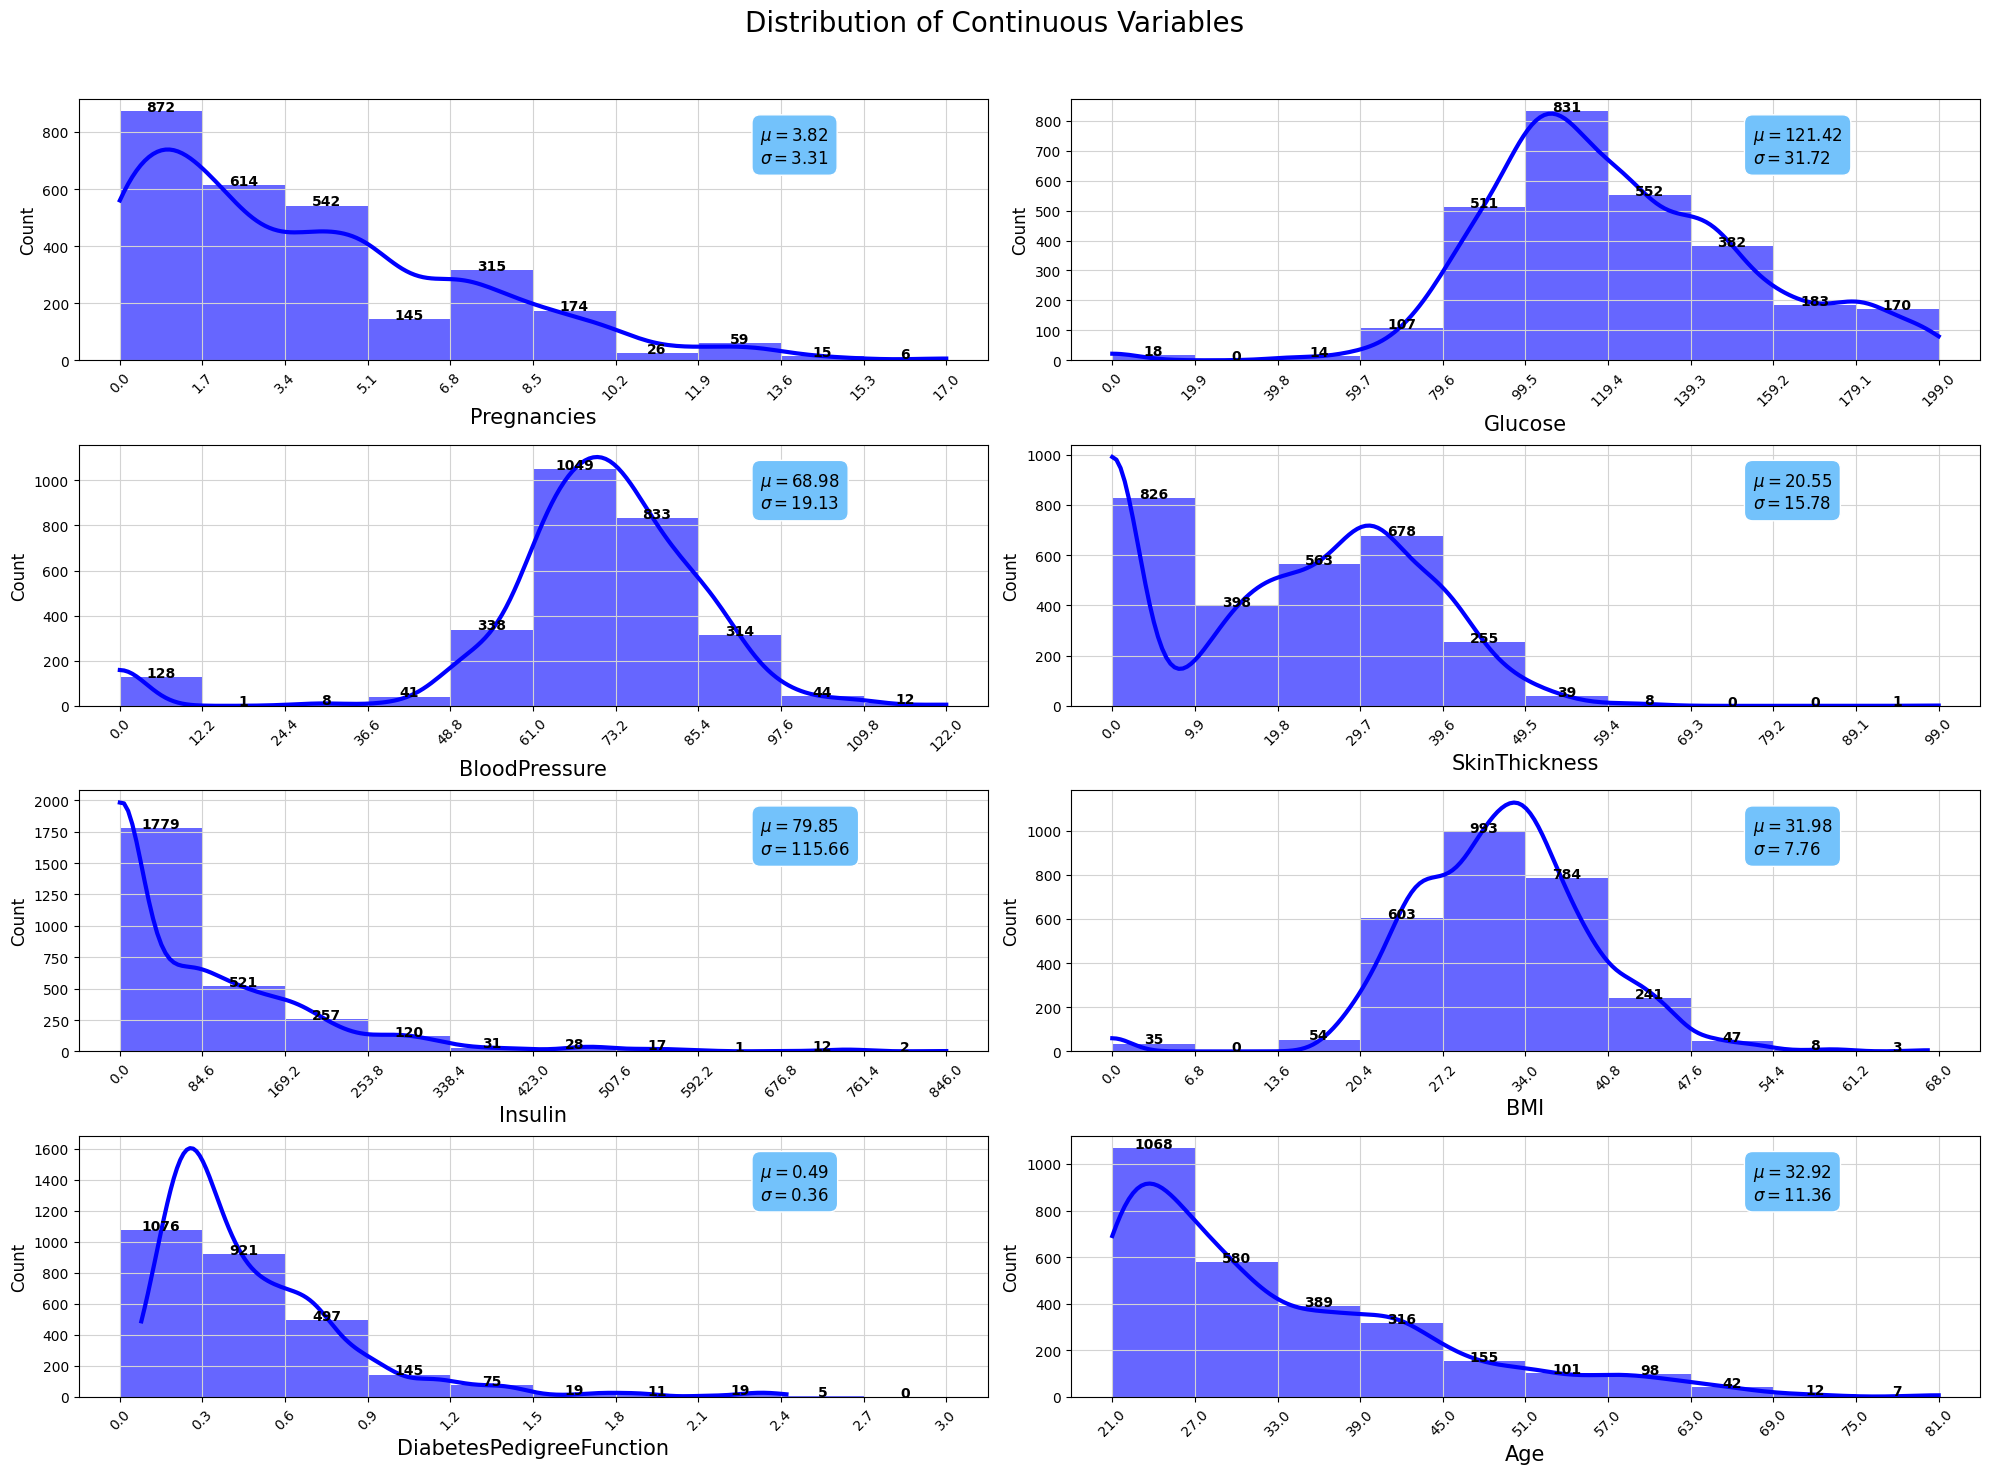

In [11]:
# Set up the subplot
fig, ax = plt.subplots(nrows=4, ncols=2, figsize=(20, 15))

# Loop to plot histograms for each continuous feature
for i, col in enumerate(df_numerical.columns):
    x = i // 2
    y = i % 2
    values, bin_edges = np.histogram(df_numerical[col], 
                                     range=(np.floor(df[col].min()), np.ceil(df_numerical[col].max())))
    
    graph = sns.histplot(data=df_numerical, x=col, bins=bin_edges, kde=True, ax=ax[x, y],
                         edgecolor='none', color='blue', alpha=0.6, line_kws={'lw': 3})
    ax[x, y].set_xlabel(col, fontsize=15)
    ax[x, y].set_ylabel('Count', fontsize=12)
    ax[x, y].set_xticks(np.round(bin_edges, 1))
    ax[x, y].set_xticklabels(ax[x, y].get_xticks(), rotation=45)
    ax[x, y].grid(color='lightgrey')
    
    
    for j, p in enumerate(graph.patches):
        ax[x, y].annotate('{}'.format(p.get_height()), (p.get_x() + p.get_width() / 2, p.get_height() + 1),
                          ha='center', fontsize=10, fontweight="bold")
    
    textstr = '\n'.join((
        r'$\mu=%.2f$' % df_numerical[col].mean(),
        r'$\sigma=%.2f$' % df_numerical[col].std()
    ))
    ax[x, y].text(0.75, 0.9, textstr, transform=ax[x, y].transAxes, fontsize=12, verticalalignment='top',
                  color='black', bbox=dict(boxstyle='round', facecolor='#73c2fb', edgecolor='white', pad=0.5))


plt.suptitle('Distribution of Continuous Variables', fontsize=20)
plt.tight_layout()
plt.subplots_adjust(top=0.92)
plt.show()

#### Bivariate Analysis

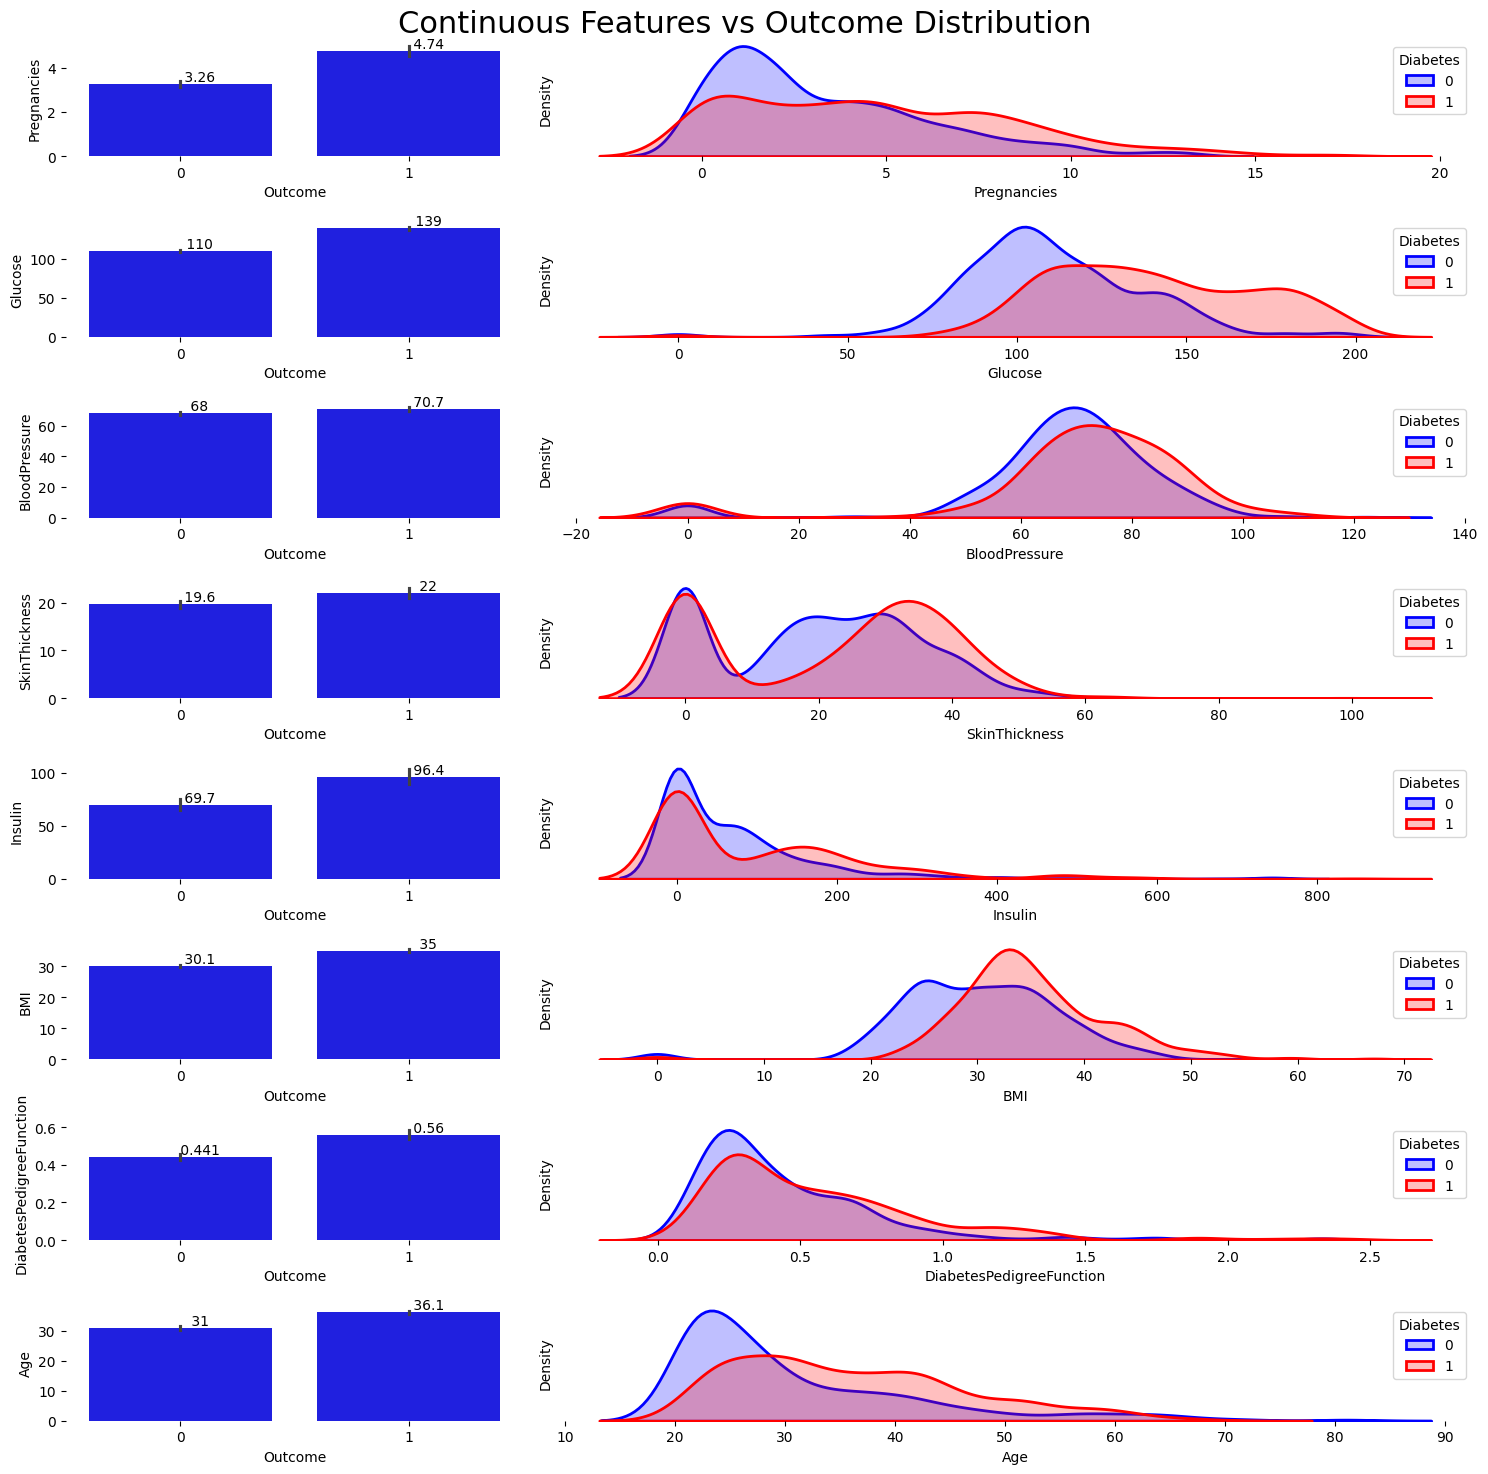

In [12]:
# Set color palette
sns.set_palette(['blue', 'red'])

# Create the subplots
fig, ax = plt.subplots(len(numerical_columns), 2, figsize=(15,15), gridspec_kw={'width_ratios': [1, 2]})

# Loop through each continuous feature to create barplots and kde plots
for i, col in enumerate(numerical_columns):
    # Barplot showing the mean value of the feature for each target category
    graph = sns.barplot(data=df, x="Outcome", y=col, ax=ax[i,0])
    
    # KDE plot showing the distribution of the feature for each target category
    sns.kdeplot(data=df[df["Outcome"]==0], x=col, fill=True, linewidth=2, ax=ax[i,1], label='0')
    sns.kdeplot(data=df[df["Outcome"]==1], x=col, fill=True, linewidth=2, ax=ax[i,1], label='1')
    ax[i,1].set_yticks([])
    ax[i,1].legend(title='Diabetes', loc='upper right')

    
    # Remove outer border barplot
    for spine in ax[i,0].spines.values():
        spine.set_visible(False)
        
    # Remove outer border kde plor
    for spine in ax[i,1].spines.values():
        spine.set_visible(False)
    
    # Add mean values to the barplot
    for cont in graph.containers:
        graph.bar_label(cont, fmt='         %.3g')
        
# Set the title for the entire figure
plt.suptitle('Continuous Features vs Outcome Distribution', fontsize=22)
plt.tight_layout()                     
plt.show()


### **Data Preprocessing**

#### Irrelevant Features Removal

All features in the dataset appear to be relevant based on our EDA. No columns seem redundant or irrelevant. Thus, we'll retain all features, ensuring no valuable information is lost.

#### Missing Value Treatment

In [13]:
df.isnull().sum().sum()


0

#### Handle Noisy Data

In [14]:
# Analyze noisy data
noisy_data = {
    'BloodPressure':  df[df['BloodPressure'] == 0],
    'SkinThickness':   df[df['SkinThickness'] == 0],
    'Insulin': df[df['Insulin'] == 0],
    'BMI':   df[df['BMI'] == 0],
}

noisy_data_count = {key: len(value) for key, value in noisy_data.items()}
noisy_data_count

{'BloodPressure': 128, 'SkinThickness': 810, 'Insulin': 1333, 'BMI': 35}

In [15]:
# Remove rows with 0 entries
df = df[df['BloodPressure'] != 0]
df = df[df['SkinThickness'] != 0]
df = df[df['Insulin'] != 0]
df = df[df['BMI'] != 0]

In [16]:
# Reset the index
df.reset_index(drop=True, inplace=True)

# Check if the noisy data has been handled
noisy_data_handled = {
    'BloodPressure':  df[df['BloodPressure'] == 0],
    'SkinThickness':   df[df['SkinThickness'] == 0],
    'Insulin': df[df['Insulin'] == 0],
    'BMI':   df[df['BMI'] == 0],
}

noisy_data_handled_count = {key: len(value) for key, value in noisy_data_handled.items()}
noisy_data_handled_count

{'BloodPressure': 0, 'SkinThickness': 0, 'Insulin': 0, 'BMI': 0}

#### Outlier Treatment

In [17]:
numerical_columns


Index(['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin',
       'BMI', 'DiabetesPedigreeFunction', 'Age'],
      dtype='object')

In [18]:
Q1 = df[numerical_columns].quantile(0.25)
Q3 = df[numerical_columns].quantile(0.75)
IQR = Q3 - Q1
outliers_count_specified = ((df[numerical_columns] < (Q1 - 1.5 * IQR)) | (df[numerical_columns] > (Q3 + 1.5 * IQR))).sum()

outliers_count_specified

Pregnancies                 42
Glucose                      5
BloodPressure               32
SkinThickness                5
Insulin                     79
BMI                         15
DiabetesPedigreeFunction    65
Age                         70
dtype: int64

#### Check Imbalanced Data

In [19]:
df['Outcome'].value_counts()


Outcome
0    917
1    512
Name: count, dtype: int64

C:\Users\AnsaB\AppData\Local\Temp\ipykernel_6404\1895387373.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x=percentage.index, y=percentage, palette=colors)  # Use palette parameter


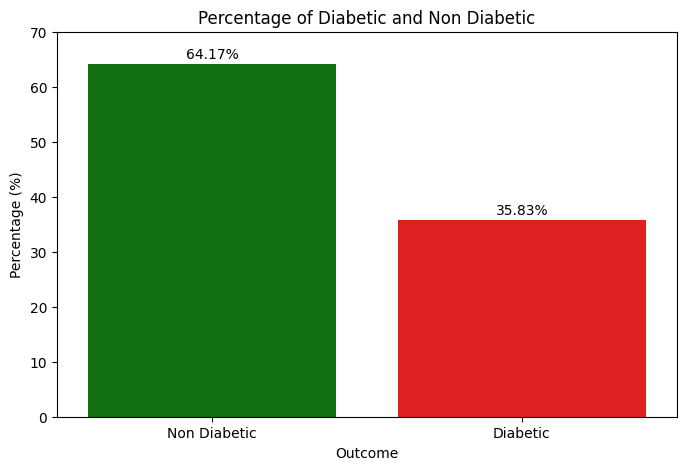

In [21]:
import seaborn as sns
import matplotlib.pyplot as plt

# Define colors for each bar
colors = ['green', 'red']  # Example colors, you can specify your own

# Calculating the percentage of each class
percentage = df['Outcome'].value_counts(normalize=True) * 100

# Plotting the percentage of each class
plt.figure(figsize=(8, 5))
ax = sns.barplot(x=percentage.index, y=percentage, palette=colors)  # Use palette parameter
plt.title('Percentage of Diabetic and Non Diabetic')
plt.xlabel('Outcome')
plt.ylabel('Percentage (%)')
plt.xticks(ticks=[0, 1], labels=['Non Diabetic', 'Diabetic'])
plt.yticks(ticks=range(0, 80, 10))

# Displaying the percentage on the bars
for i, p in enumerate(percentage):
    ax.text(i, p + 0.5, f'{p:.2f}%', ha='center', va='bottom')

plt.show()

#### Split the Dataset

In [22]:
# Define the features (X) and the output labels (y)
X = df.drop('Outcome', axis=1)
y = df['Outcome'] 

In [23]:
# Splitting data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0, stratify=y)

In [24]:
print(pd.Series(y_train).value_counts(normalize = True))
print(pd.Series(y_test).value_counts(normalize = True))

Outcome
0    0.641295
1    0.358705
Name: proportion, dtype: float64
Outcome
0    0.643357
1    0.356643
Name: proportion, dtype: float64


### **XGBoost Model Building**

In [25]:
# Define the model
xgb_base = xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=0)

####  XGBoost Hyperparameter Tuning

In [26]:
# Define the parameter grid
param_grid_xgb = {
    'n_estimators': [250, 350],
    'learning_rate': [0.01, 0.1],
    'max_depth': [7, 8],
    'subsample': [0.7, 0.8],
    'colsample_bytree': [0.8, 0.9],
    'scale_pos_weight': [1, (y_train == 0).sum() / (y_train == 1).sum()]
}

In [28]:
def tune_clf_hyperparameters(clf, param_grid, X_train, y_train, scoring='f1', n_splits=5):
    '''
    This function optimizes the hyperparameters for a classifier by searching over a specified hyperparameter grid. 
    It uses GridSearchCV and cross-validation (StratifiedKFold) to evaluate different combinations of hyperparameters. 
    The combination with the highest F1-score for class 1 (canceled bookings) is selected as the default scoring metric. 
    The function returns the classifier with the optimal hyperparameters.
    '''
    
    # Create the cross-validation object using StratifiedKFold to ensure the class distribution is the same across all the folds
    cv = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=0)

    # Create the GridSearchCV object
    clf_grid = GridSearchCV(clf, param_grid, cv=cv, scoring=scoring, n_jobs=-1)

    # Fit the GridSearchCV object to the training data
    clf_grid.fit(X_train, y_train)

    # Get the best hyperparameters
    best_hyperparameters = clf_grid.best_params_
    
    # Return best_estimator_ attribute which gives us the best model that has been fitted to the training data
    return clf_grid.best_estimator_, best_hyperparameters

In [29]:
# Call the function for hyperparameter tuning
best_xgb, best_xgb_hyperparams = tune_clf_hyperparameters(xgb_base, param_grid_xgb, X_train, y_train)

In [32]:
print('XGBoost Optimal Hyperparameters: \n', best_xgb_hyperparams)


XGBoost Optimal Hyperparameters: 
 {'colsample_bytree': 0.8, 'learning_rate': 0.1, 'max_depth': 7, 'n_estimators': 350, 'scale_pos_weight': 1, 'subsample': 0.7}


#### XGBoost Model Evaluation

In [33]:
def metrics_calculator(clf, X_test, y_test, model_name):
    '''
    This function calculates all desired performance metrics for a given model on test data.
    The metrics are calculated specifically for class 1.
    '''
    y_pred = clf.predict(X_test)
    result = pd.DataFrame(data=[accuracy_score(y_test, y_pred),
                                precision_score(y_test, y_pred, pos_label=1),
                                recall_score(y_test, y_pred, pos_label=1),
                                f1_score(y_test, y_pred, pos_label=1),
                                roc_auc_score(y_test, clf.predict_proba(X_test)[:,1])],
                          index=['Accuracy','Precision (Class 1)','Recall (Class 1)','F1-score (Class 1)','AUC (Class 1)'],
                          columns = [model_name])
    
    result = (result * 100).round(2).astype(str) + '%'                            
    return result

In [34]:
def model_evaluation(clf, X_train, X_test, y_train, y_test, model_name):
    '''
    This function provides a complete report of the model's performance including classification reports, 
    confusion matrix and ROC curve.
    '''
    sns.set(font_scale=1.2)
    
    # Generate classification report for training set
    y_pred_train = clf.predict(X_train)
    print("\n\t  Classification report for training set")
    print("-"*55)
    print(classification_report(y_train, y_pred_train))

    # Generate classification report for test set
    y_pred_test = clf.predict(X_test)
    print("\n\t   Classification report for test set")
    print("-"*55)
    print(classification_report(y_test, y_pred_test))
    
    # Create figure and subplots 
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 5), dpi=100, gridspec_kw={'width_ratios': [2, 2, 1]})
    
    # Define a colormap resembling an apple (red theme)
    apple_red = LinearSegmentedColormap.from_list('apple_red', [(0, '#FF0000'), (1, '#FFFFFF')])
    apple_red_r = apple_red.reversed() 
    
    # Plot confusion matrix for test set
    ConfusionMatrixDisplay.from_estimator(clf, X_test, y_test, colorbar=False, cmap=apple_red_r, ax=ax1)
    ax1.set_title('Confusion Matrix for Test Data')                                     
    ax1.grid(False)
    
    # Plot ROC curve for test data and display AUC score 
    RocCurveDisplay.from_estimator(clf, X_test, y_test, ax=ax2)
    ax2.set_xlabel('False Positive Rate')
    ax2.set_ylabel('True Positive Rate')
    ax2.set_title('ROC Curve for Test Data (Positive label: 1)')
    
    # Report results for the class specified by positive label
    result = metrics_calculator(clf, X_test, y_test, model_name)
    table = ax3.table(cellText=result.values, colLabels=result.columns, rowLabels=result.index, loc='center')
    table.scale(0.6, 2)
    table.set_fontsize(12)
    ax3.axis('tight')
    ax3.axis('off')
    # Modify color 
    for key, cell in table.get_celld().items():
        if key[0] == 0:
            cell.set_color('#FF0000')
    plt.tight_layout()
    plt.show()


	  Classification report for training set
-------------------------------------------------------
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       733
           1       1.00      1.00      1.00       410

    accuracy                           1.00      1143
   macro avg       1.00      1.00      1.00      1143
weighted avg       1.00      1.00      1.00      1143


	   Classification report for test set
-------------------------------------------------------
              precision    recall  f1-score   support

           0       0.97      0.99      0.98       184
           1       0.98      0.94      0.96       102

    accuracy                           0.97       286
   macro avg       0.97      0.97      0.97       286
weighted avg       0.97      0.97      0.97       286



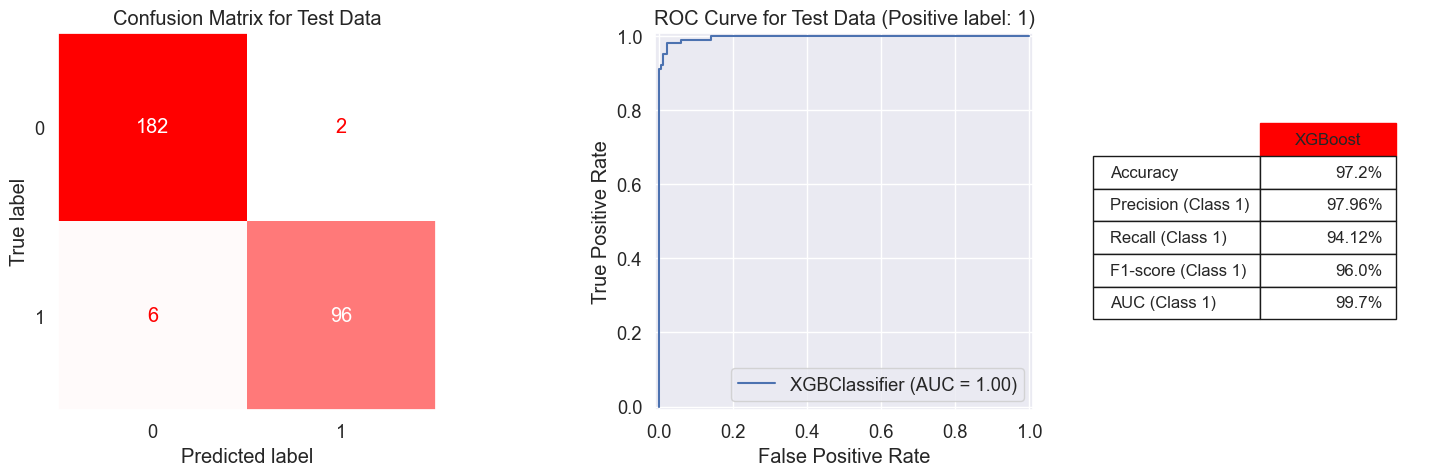

In [35]:
model_evaluation(best_xgb, X_train, X_test, y_train, y_test, 'XGBoost')


In [36]:
# Save the final performance of XGBoost classifier
xgb_result = metrics_calculator(best_xgb, X_test, y_test, 'XGBoost')
xgb_result

,XGBoost
Accuracy,97.2%
Precision (Class 1),97.96%
Recall (Class 1),94.12%
F1-score (Class 1),96.0%
AUC (Class 1),99.7%
